In [67]:
import numpy as np
import random
from tqdm.auto import tqdm
from dataclasses import dataclass
import copy
from tree_node import TreeNode
from tree import Tree

In [68]:
problem = np.load('../data/problem_0.npz')
x = problem['x']
# x = np.array([[1,1,1], [1,1,1]])

y = problem['y']


# convert normal python array into numpy ndarray
# x = np.array(x)

PROBLEM_SIZE  = np.shape(x)[0]
print(PROBLEM_SIZE)

print(np.shape(x))

2
(2, 1000)


In [69]:
BINARY_OPERATORS = {
    "+": np.add,
    "-": np.subtract,
    "*": np.multiply,
    "/": np.divide
}

#https://numpy.org/doc/2.1/reference/routines.math.html
UNARY_OPERATORS = {
        "": lambda x: x,  
        "sin": np.sin,
        "cos": np.cos,
        "tan":np.tan,
        "log": np.log,
        "arccos": np.arccos,
        "arcsin":np.arcsin,
        "arctan":np.arctan,
        "sqrt":np.sqrt,
        "cbrt":np.cbrt,
        "abs":np.abs,
        "reciprocal":np.reciprocal,
        # "exp": np.exp
    }

#VARIABLES = [f"X_{i}" for i in range(PROBLEM_SIZE)]

#VARIABLES_WEIGHTS = [[1/len(VARIABLES) for _ in range(len(VARIABLES))]]
VARIABLES_MAP = {f"X_{i}": x[i] for i in range(PROBLEM_SIZE)}    # {'X_0': [1, 2, 3], 'X_1': [4, 5, 6], 'X_2': [7, 8, 9]}
#LEAVES = [i for i in range(-MAX_COEFFICIENT, MAX_COEFFICIENT)] + list(VARIABLES_MAP.keys())
# print(VARIABLES_MAP)
# print(LEAVES)



In [70]:
POPULATION_SIZE = 150
OFFSPRING_SIZE = 20
MAX_ITERATIONS = 250

In [71]:
def mse(y_computed: np.ndarray, y_expected: np.ndarray):
    # 100*np.square(y_train-d3584.f(x_train)).sum()/len(y_train):g}")
    return 100 * np.square(y_expected - y_computed).sum() / len(y_expected)

def mse2(y_computed: np.ndarray, y_expected: np.ndarray):
    return np.square(y_expected - y_computed).sum() / len(y_expected)


In [72]:
def optimize_initial_coefficients(x, y):
    # Get statistics from y
    y_mean = np.mean(y)
    y_std = np.std(y)
    y_min, y_max = np.min(y), np.max(y)
    
    # For each feature in x
    coefficients = []
    for i in range(x.shape[0]):
        x_i = x[i]
        x_mean = np.mean(x_i)
        x_std = np.std(x_i)
        
        # Basic scaling coefficient to match ranges
        coeff = y_std / (x_std + 1e-8)  # avoid division by zero
        
        coefficients.append(coeff)
    
    return np.array(coefficients)

def get_coefficient_ranges():
    # Get rough scaling factors
    base_coeffs = optimize_initial_coefficients(x, y)
    
    # Create ranges around these coefficients
    ranges = []
    for coeff in base_coeffs:
        # Create range from 0.1× to 10× the optimized coefficient
        min_coeff = coeff * 0.1
        max_coeff = coeff * 10
        ranges.append((min_coeff, max_coeff))
        
    return ranges

In [73]:
ranges = get_coefficient_ranges()
ranges

[(np.float64(0.10015993129077867), np.float64(10.015993129077867)),
 (np.float64(0.32265347886198437), np.float64(32.265347886198434))]

In [74]:
def compute_coefficient(x_i):
    """returns a random float coefficient between -MAX_COEFFICIENT and MAX_COEFFICIENT"""
    x_array = list(VARIABLES_MAP.keys())
    i = x_array.index(x_i)
    return np.random.uniform(ranges[i][0],ranges[i][1] )

def optimize_initial_coefficients(x, y):
    # Get statistics from y
    y_mean = np.mean(y)
    y_std = np.std(y)
    y_min, y_max = np.min(y), np.max(y)
    
    # For each feature in x
    coefficients = []
    for i in range(x.shape[0]):
        x_i = x[i]
        x_mean = np.mean(x_i)
        x_std = np.std(x_i)
        
        # Basic scaling coefficient to match ranges
        coeff = y_std / (x_std + 1e-8)  # avoid division by zero
        
        coefficients.append(coeff)
    
    return np.array(coefficients)

def get_constant_ranges(y):
    y_mean = np.mean(y)
    y_std = np.std(y)
    y_min, y_max = np.min(y), np.max(y)
    
    # Create different ranges based on operation context
    ranges = {
        'add_sub': (-y_std, y_std),  # for addition/subtraction
        'mult_div': (-2.0, 2.0),     # for multiplication/division
        'small': (-1.0, 1.0),        # for fine-tuning
        'powers': range(-3, 3)        # for exponents, usually small integers
    }
    return ranges

def generate_constant(operation_type):
    if operation_type in UNARY_OPERATORS.keys():
        return generate_safe_constant() # TODO generate constant generator for unary oeprators
    
    ranges = get_constant_ranges(y)

    
    if random.random() < 0.5:
        operation_type = 'small'
    else:
        if operation_type == '+' or operation_type == '-':
            operation_type = 'add_sub'
        elif operation_type == '*' or operation_type == '/':
            operation_type = 'mult_div'
        
        else:      # Integer constants for exponents
            return np.random.choice(ranges['powers'])
        
    min_val, max_val = ranges[operation_type]
    # Float constants for other operations
    return np.random.uniform(min_val, max_val)



def generate_safe_constant():
    """Generate a constant that would be safe for any operation"""
    y_std = np.std(y)
    y_mean = np.mean(y)
    
    # Start with a conservative range
    min_val = 0.1  # Avoid zero for division
    max_val = min(2.0, y_std)  # Keep it reasonable for both mult and add
    
    return np.random.uniform(min_val, max_val)

In [75]:
# MAX_COEFFICIENT = np.abs(min(y)) # adjustable depending on output scale
# MAX_COEFFICIENT = 1 # adjustable depending on output scale

# def compute_coefficient(x_i):
#     """returns a random float coefficient between -MAX_COEFFICIENT and MAX_COEFFICIENT"""
#     x_array = list(VARIABLES_MAP.keys())
#     return np.random.choice(ranges[x_array.index(x_i)])

def optimize_initial_coefficients(x, y):
    # Get statistics from y
    y_mean = np.mean(y)
    y_std = np.std(y)
    y_min, y_max = np.min(y), np.max(y)
    
    # For each feature in x
    coefficients = []
    for i in range(x.shape[0]):
        x_i = x[i]
        x_mean = np.mean(x_i)
        x_std = np.std(x_i)
        
        # Basic scaling coefficient to match ranges
        coeff = y_std / (x_std + 1e-8)  # avoid division by zero
        
        coefficients.append(coeff)
    
    return np.array(coefficients)

def compute_coefficients():
    # Get rough scaling factors
    base_coeffs = optimize_initial_coefficients(x, y)
    
    # Create ranges around these coefficients
    ranges = []
    for coeff in base_coeffs:
        # Create range from 0.1× to 10× the optimized coefficient
        min_coeff = coeff * 0.1
        max_coeff = coeff * 10
        ranges.append((min_coeff, max_coeff))
        
    return ranges


def are_compatible(operator, value, base=0):
    match operator:
        case "/":
            if not isinstance(value,np.ndarray):
                return False if value == 0 else True
            else : # check if all values are non-zero
                return False if (0 in value) else True
            
        case "^":
            if not isinstance(value, np.ndarray) and not isinstance(base, np.ndarray): # (non array) ^ (non array)
                return False if (base < 0 and not int(value) == value) or (base == 0 and value < 0) else True
            elif not isinstance(value, np.ndarray) and isinstance(base, np.ndarray): # array ^ (non array)
                return False if (not int(value) == value and np.any(base < 0)) or (value < 0 and np.any(base == 0)) else True
            elif isinstance(value, np.ndarray) and not isinstance(base, np.ndarray): # (non array) ^ array
                return False if (base < 0 and any((not int(i) == i) for i in value)) or (base == 0 and np.any(value < 0)) else True
            else : # array ^ array
                for i in range(len(value)):                    
                    if (base[i] < 0 and not int(value[i]) == value[i]) or (base[i] == 0 and value[i] < 0):
                        return False 
                return True
            
        case "log" :
            if not isinstance(value,np.ndarray):
                return False if value <= 0 else True
            else : # check if all values are non-negative
                return False if (np.any(value <= 0)) else True
        
        case "arccos" :
            if not isinstance(value,np.ndarray):
                return False if value < -1 or value > 1 else True
            else : # check if all values are between -1 and 1
                return False if (np.any(value < -1 ) or np.any(value > 1) ) else True
            
        case "arcsin" :
            if not isinstance(value,np.ndarray):
                return False if value < -1 or value > 1 else True
            else : # check if all values are between -1 and 1
                return False if (np.any(value < -1 )or np.any(value > 1) )else True
        
        case "sqrt" :
            if not isinstance(value,np.ndarray):
                return False if value < 0 else True
            else : # check if all values are non-negative
                return False if (np.any(value < 0) )else True

        case "reciprocal" :
            if not isinstance(value,np.ndarray):
                return False if value == 0 else True
            else:
                return False if (np.any(value == 0)) else True
            
        case "tan" :
            if not isinstance(value,np.ndarray):
                k = (value - np.pi / 2) / np.pi
                return False if k.is_integer() else True
            else:
                for i in range(len(value)):
                    k = (value[i] - np.pi / 2) / np.pi
                    if k.is_integer():
                        return False
                return True

        case _:
            return True


In [76]:
# def similarity(operator, x_i, y):
#     return 1 / (1+ mse2(operator(x_i), y))

def similarity(operator, x_i, y):
    # Add normalization to make comparison fairer across different scales
    y_pred = operator(x_i)
    y_norm = (y - y.mean()) / (y.std() + 1e-8)
    y_pred_norm = (y_pred - y_pred.mean()) / (y_pred.std() + 1e-8)
    return 1 / (1 + mse2(y_pred_norm, y_norm))

# def compute_weights_corr():
#     weights = {op: 0 for op in UNARY_OPERATORS.keys()}
    
#     for op in weights:
#         # max_sim = 0
#         max_correlation = 0
#         for i in range(np.shape(x)[0]):
#             if (are_compatible(op, x[i])):
#                 # sim = similarity(UNARY_OPERATORS[op], x[i], y)
#                 # max_sim = max(max_sim, sim)
#                 transformed = UNARY_OPERATORS[op](x[i])
#                 correlation = abs(stats.pearsonr(transformed, y)[0])
#                 max_correlation = max(max_correlation, correlation)
#         # weights[op] = max_sim
#         weights[op] = max_correlation
    
#       # Normalize weights
#     total = sum(weights.values())
#     if total > 0:
#         weights = {k: v/total for k, v in weights.items()}
#     else:
#         # If all correlations failed, use uniform weights
#         weights = {k: 1.0/len(UNARY_OPERATORS) for k in UNARY_OPERATORS.keys()}
        
#     return weights

def compute_weights_sim(operators):
    weights = {op: 0 for op in operators}
    
    for op in weights:
        max_sim = 0
        for i in range(np.shape(x)[0]):
            if (are_compatible(op, x[i])):
                sim = similarity(UNARY_OPERATORS[op], x[i], y)
                max_sim = max(max_sim, sim)
               
        weights[op] = max_sim
    
      # Normalize weights
    total = sum(weights.values())
    if total > 0:
        weights = {k: v/total for k, v in weights.items()}
    else:
        # If all correlations failed, use uniform weights
        weights = {k: 1.0/len(UNARY_OPERATORS) for k in UNARY_OPERATORS.keys()}
        
    return weights

w =  compute_weights_sim(UNARY_OPERATORS.keys())
print(w)
print(sum(w.values()))



{'': np.float64(0.17827438485659855), 'sin': np.float64(0.12257107827692593), 'cos': np.float64(0.060135028009058455), 'tan': np.float64(0.06158121715886166), 'log': np.float64(0.0), 'arccos': np.float64(0.057759902730593476), 'arcsin': np.float64(0.061586571027254), 'arctan': np.float64(0.17087986128844349), 'sqrt': np.float64(0.0), 'cbrt': np.float64(0.16454195867014046), 'abs': np.float64(0.06082183578409751), 'reciprocal': np.float64(0.06184816219802644)}
0.9999999999999999


In [77]:
# # weights
# UNARY_OPERATORS_WEIGHTS = compute_weights_sim()
# BINARY_OPERATORS_WEIGHTS = [[1/len(BINARY_OPERATORS.keys()) for _ in range(len(BINARY_OPERATORS.keys()))]]
# # UNARY_OPERATORS_WEIGHTS

## Tree helper functions

In [78]:
def random_initial_tree(depth, maxdepth, variables, binary_operators, unary_operators):
    if depth == maxdepth:  # Add a variable until they are all chosen, if yes add a number
        if variables:
            var = random.choice(variables)
            leaf = TreeNode(var)
            leaf.coefficient = compute_coefficient(var)
            variables.remove(var)
        else:
            # leaf = TreeNode(compute_coefficient())  # TODO change to compute constant
            leaf = TreeNode(generate_safe_constant())
            leaf.coefficient = 1
        return leaf
    
    elif depth == maxdepth - 1: # Add a unary operator
        node = TreeNode(None)
        node.right = random_initial_tree(depth + 1, maxdepth, variables, binary_operators, unary_operators)
        node.left = None
    
        available_unary = [op for op in unary_operators if are_compatible(op, np.multiply(VARIABLES_MAP[node.right.value], node.right.coefficient) if node.right.value in VARIABLES_MAP else node.right.value)]
        available_weights = list(compute_weights_sim(available_unary).values())
        node.value = np.random.choice(available_unary, p=available_weights) # If a choice of a variant unary operator was made, choose a random variant from all the possible ones
        return node
    
    else: # Add a binary operator
        node = TreeNode(None)
        node.left = random_initial_tree(depth + 1, maxdepth, variables, binary_operators, unary_operators)
        node.right = random_initial_tree(depth + 1, maxdepth, variables, binary_operators, unary_operators)
        available_binary = [op for op in binary_operators if are_compatible(op, node.right.evaluate_tree_from_node(VARIABLES_MAP, BINARY_OPERATORS, UNARY_OPERATORS), node.left.evaluate_tree_from_node(VARIABLES_MAP, BINARY_OPERATORS, UNARY_OPERATORS))]
        node.value = random.choice(available_binary) # Choose a random binary operator from all the possible ones
        return node
    
def get_random_leaf():
    if random.choice([0, 1]): # TODO could choose larger subtree
        random_leaf = TreeNode(random.choice(list(VARIABLES_MAP.keys())))
        random_leaf.coefficient = compute_coefficient(random_leaf.value)
    else:
        random_leaf = TreeNode(generate_safe_constant())
        random_leaf.coefficient = 1
    return random_leaf
    
def get_parent(root, target):
    """
    Find the parent of a target node in the tree.
    """
    # The 'is' operator is unaffected by __eq__ and always checks if two variables refer to the same object in memory.
    # https://chatgpt.com/share/678294b0-ed60-8004-932d-40c051582d22
    if not root or root is target:
        return None
    if root.left is target or root.right is target:
        return root
    return get_parent(root.right, target) or get_parent(root.left, target)

def validate_after_replacement(root, replaced_node, unary_operators, binary_operators):
    """
    Validate the tree after replacing a subtree.

    Args:
        root (TreeNode): The root of the tree.
        replaced_node (TreeNode): The node that was replaced.
        unary_operators (list): List of unary operators.
        binary_operators (list): List of binary operators.

    Returns:
        bool: True if the tree is valid, False otherwise.
    """
    current = replaced_node
    while current:
        parent = get_parent(root, current)
        if (parent and parent.value in unary_operators and not are_compatible(parent.value, current.evaluate_tree_from_node(VARIABLES_MAP, BINARY_OPERATORS, UNARY_OPERATORS))) \
        or (parent and parent.value in binary_operators and not are_compatible(parent.value, current.evaluate_tree_from_node(VARIABLES_MAP, BINARY_OPERATORS, UNARY_OPERATORS), parent.left.evaluate_tree_from_node(VARIABLES_MAP, BINARY_OPERATORS, UNARY_OPERATORS))):
            return False
        current = parent  # Traverse up to the root
    return True
    
def swap_subtrees(source_tree, target_tree):
    """
    Try to swap subtrees from source_tree to target_tree.

    Args:
        source_tree (Tree): The source tree.
        target_tree (Tree): The target tree.

    Returns:
        bool: True if a swap was successful, False otherwise.
    """


    # nodoA = random.choice(lista di nodi di A)
    source_nodes = source_tree.get_nodes()

    while source_nodes:
        source_node = random.choice(source_nodes)
        if try_swap(source_node, target_tree):
            return True
        source_nodes.remove(source_node)
    return False

def try_swap(source_node: TreeNode, target_tree: Tree, filter_leaves_parents=False):
    target_nodes = target_tree.get_non_leaves_nodes()
    if filter_leaves_parents:
        # Consider only nodes whose children are not leaves to avoid adding subtree to leaf in mutation
        target_nodes = [node for node in target_nodes if node.right.right or node.right.left]
    unary_operators = list(UNARY_OPERATORS.keys())
    binary_operators = list(BINARY_OPERATORS.keys())
    while target_nodes:
        # target_node -> parent del nodo in target_tree che verrà sostituito con source_tree
        target_node = random.choice(target_nodes)

        if (target_node.value in unary_operators and are_compatible(target_node.value, source_node.evaluate_tree_from_node(VARIABLES_MAP, BINARY_OPERATORS, UNARY_OPERATORS))):
            tmp = target_node.right
            target_node.right = source_node
            if validate_after_replacement(target_tree.root, target_node, unary_operators, binary_operators):
                return True
            target_node.right = tmp

        elif (target_node.value in binary_operators):
            choice = random.choice(["right", "left"])
            if choice == "right" and are_compatible(target_node.value, source_node.evaluate_tree_from_node(VARIABLES_MAP, BINARY_OPERATORS, UNARY_OPERATORS), target_node.left.evaluate_tree_from_node(VARIABLES_MAP, BINARY_OPERATORS, UNARY_OPERATORS)):
                tmp = target_node.right
                target_node.right = source_node
                if validate_after_replacement(target_tree.root, target_node, unary_operators, binary_operators):
                    return True
                target_node.right = tmp
            elif choice == "left" and are_compatible(target_node.value, target_node.right.evaluate_tree_from_node(VARIABLES_MAP, BINARY_OPERATORS, UNARY_OPERATORS), source_node.evaluate_tree_from_node(VARIABLES_MAP, BINARY_OPERATORS, UNARY_OPERATORS)):
                tmp = target_node.left
                target_node.left = source_node
                if validate_after_replacement(target_tree.root, target_node, unary_operators, binary_operators):
                    return True
                target_node.left = tmp
        target_nodes.remove(target_node)
    return False

## Steps
- We treat a possible solution as a tree. The tree has attribute root, which is the root of the tree of class TreeNode and max_depth.
- Generate random tree
    - we need each variable at least once 
    - each variable has exactly one coefficient chosen as a random float number in the range [?, ?]
    - each variable has exactly one unary operator
    - unary operator is chosen as: 50% chance of "" (i.e. no change to the variable), 50% chance of choosing among all other unary operators
        - check if the unary operator is appliable to the variable ->
            ```
            leaves_map = {}
            for e in leaves:
                available_unary_operators = [op for op in list(UNARY_OPERATORS.keys()) if op.is_applicable(e)]
                chosen_unary_operator = 50% chance of "" (i.e. no change to the variable), 50% chance of choosing among [available_unary_operators]
                leaves_map[e] = [chosen_unary_operator]
            # leaves = [-2, 3]
            # leaves_map = {-2: square, 3: log}
            for e in leaves:
                node = leaves_map[e]
                node.left = null
                node.right = e
                # insert node to tree
            ```
    - number of leaves = nearest power of two greater than keys.length()
    - number of actual leaves = [number of leaves] * 2
    - number of coefficients = [number of leaves] - keys.length()
    - number of binrary operators = total number of nodes in  tree with [number of leaves] leaves - [number of leaves]]
    - validate tree
    - if valid, return tree
    - else, ?
- Example:
    - x.length() = 3
    - number of leaves = 4
    - number of actual leaves = 8
    - number of coefficients = 1
    - number of operands = 3

    ```bash
                    +
            /                  \
            *                    +
        /      \           /        \
      u        1          1          u
    /   \    /   \      /   \       /  \
    nul  *  nul   *    nul    *     nul *
    ```
### EA approach
- Individual is rapresented as a tree and a fitness
    - fitness is a tuple of 2 values: (-mse, right_sign_100)
        - right_sign_100 is the percentage of correct sign predictions
        - mse is the mean squared error
- Classic Genetic Programming
    - Key elements 
    - Representation: tree structures
    - Recombination: exchange of subtrees
    - Mutation: random change in trees
        - subtree mutation -> replace  entire subtree
        - point  mutation -> change single node
        - permutation -> exchange node right with left
        - hoist -> take subtree and make it root
        - expansion -> take random leaf and replace it with a new subtree
        - collapse -> take a subtree and replace it with leaf
    - Population model: generational
    - Parent selection: fitness proportional
    - Survivor selection: deterministic

##next

    - finish implementing mutations
    - find way to reduce tree dimension
    - add weights to opertors
    - add check if fitness doesn't improve , stop early
    - 

##problems
    - overflow
    - initial tree with 4xnodes has invalid values
    - 


## Individual definition

In [79]:
@dataclass
class Individual:
    genome: Tree
    fitness: tuple

## Fitness evaluation

In [80]:
def fitness(sol: Tree):
    y_computed = sol.root.evaluate_tree_from_node(VARIABLES_MAP, BINARY_OPERATORS, UNARY_OPERATORS)
    right_sign_100 = 100 * np.sum(np.sign(y_computed) == np.sign(y)) / len(y)
    return  -mse(y_computed, y), right_sign_100

# Combine fitness components into a single score
# def compute_combined_score(fitness_values, weight_mse=0.5, weight_sign=0.5):
#     mse_score, right_sign_score = fitness_values
#     # Normalize `right_sign_score` to [0, 1] (optional if already in that range)
#     normalized_sign_score = right_sign_score / 100
#     # Weighted combination
#     combined_score = weight_mse * mse_score + weight_sign * normalized_sign_score
#     return combined_score

def sort_individuals(population, mse_weight=0.6):
    # Normalize both components to [0,1] scale across the population
    mse_scores = np.array([ind.fitness[0] for ind in population])
    sign_scores = np.array([ind.fitness[1] for ind in population])
    
    # Min-max normalization
    mse_norm = (mse_scores - mse_scores.min()) / (mse_scores.max() - mse_scores.min())
    sign_norm = sign_scores / 100  # Already in [0,100] range
    
    # Combine scores with weighted sum
    combined_scores = mse_weight * mse_norm + (1 - mse_weight) * sign_norm
    
    # Sort population based on combined scores (descending order)
    sorted_population = [x for _, x in sorted(zip(combined_scores, population), 
                                            key=lambda pair: pair[0], 
                                            reverse=True)]
    return sorted_population

def compute_score(individual, population, mse_weight=0.6):
     # Normalize both components to [0,1] scale across the population
    mse_scores = np.array([ind.fitness[0] for ind in population])
    sign_scores = np.array([ind.fitness[1] for ind in population])
    
    # Min-max normalization
    mse_norm = (individual.fitness[0] - mse_scores.min()) / (mse_scores.max() - mse_scores.min())
    sign_norm = individual.fitness[1] / 100  # Already in [0,100] range
    
    # Combine scores with weighted sum
    return mse_weight * mse_norm + (1 - mse_weight) * sign_norm


## Initial solution generation

In [81]:
def generate_initial_solution(input_variables=list(VARIABLES_MAP.keys())):
    variables = input_variables[:]
    n_variables = len(variables)
    if n_variables != 0:
        n_leaves = int(2 ** np.ceil(np.log2(n_variables)))
        n_actual_leaves = n_leaves * random.choice([2, 4])
        binary_operators = list(BINARY_OPERATORS.keys())[:]
        unary_operators = list(UNARY_OPERATORS.keys())[:]
        max_depth = np.log2(n_actual_leaves)
    # else :
    #     n_leaves = 1
    #     n_actual_leaves = n_leaves * 2
    #     binary_operators = list(BINARY_OPERATORS.keys())[:]
    #     unary_operators = list(UNARY_OPERATORS.keys())[:]
    #     unary_operators.remove("")
    #     max_depth = np.log2(n_actual_leaves)

    while True:
        root = random_initial_tree(0, max_depth, variables, binary_operators, unary_operators)
        try:
            #root.print_tree_from_node()
            if root.validate_tree_from_node(VARIABLES_MAP, BINARY_OPERATORS, UNARY_OPERATORS):
                root.evaluate_tree_from_node(VARIABLES_MAP, BINARY_OPERATORS, UNARY_OPERATORS)
                tree = Tree(root, max_depth)
                return tree
            else:
                print("not valid")
        except:
            pass
        variables = input_variables[:]
            
""" 
def wrapper(x):
    tree = generate_initial_solution(x)
    return evaluate_tree(tree.root)
"""

' \ndef wrapper(x):\n    tree = generate_initial_solution(x)\n    return evaluate_tree(tree.root)\n'

## Crossover and mutations

In [82]:

def xover(population: list[Individual])-> tuple[Tree, tuple]:
    parents = random.choices(population, k=2)

    # reproduce
    c1 = copy.deepcopy(parents[0].genome)
    c2 = copy.deepcopy(parents[1].genome)

    success = swap_subtrees(c1, c2)

    c_fitness = fitness(c2)

    if not success:
        # mutation
        mutation(c2)

    return c2, c_fitness


def subtree_mutation(target_tree: Tree):
    # generate a random source tree to substitute into target_tree

    num_variables = np.random.randint(1, len(VARIABLES_MAP.keys())) if len(VARIABLES_MAP.keys()) > 1 else 1  # take a random number of variables
    variables = random.sample(list(VARIABLES_MAP.keys()), num_variables)

    source_tree_root = generate_initial_solution(variables).root

    return try_swap(source_tree_root, target_tree, True)

def point_mutation(target_tree: Tree):
    nodes = target_tree.get_nodes()
    while nodes:
        node = random.choice(nodes)
        unary_operators = [op for op in  list(UNARY_OPERATORS.keys()) if op != node.value]
        unary_weights = {op: i for op,i in compute_weights_sim(unary_operators).items()}
        binary_operators = [op for op in list(BINARY_OPERATORS.keys()) if op != node.value]
        # mutate unary operator with another one
        if (node.value in UNARY_OPERATORS.keys()):
            while unary_operators:
                tmp = node.value
                node.value = np.random.choice(list(unary_weights.keys()), p=list(unary_weights.values()))
                if are_compatible(node.value, node.right.evaluate_tree_from_node(VARIABLES_MAP, BINARY_OPERATORS, UNARY_OPERATORS)) and validate_after_replacement(target_tree.root, node, unary_operators, binary_operators):
                    return True
                unary_operators.remove(node.value)
                unary_weights = {op: i for op,i in compute_weights_sim(unary_operators).items()}
                node.value = tmp

        # mutate binary operator with another one
        elif (node.value in BINARY_OPERATORS.keys()):
            while binary_operators:
                tmp = node.value
                node.value = random.choice(binary_operators)
                if are_compatible(node.value, node.right.evaluate_tree_from_node(VARIABLES_MAP, BINARY_OPERATORS, UNARY_OPERATORS), node.left.evaluate_tree_from_node(VARIABLES_MAP, BINARY_OPERATORS, UNARY_OPERATORS)) and validate_after_replacement(target_tree.root, node, binary_operators, binary_operators):
                    return True
                binary_operators.remove(node.value)
                node.value = tmp

        # mutate variable
        elif node.value in VARIABLES_MAP.keys():
            # change the coefficient
            tmp_c = node.coefficient
            tmp_v = node.value
            node.coefficient = compute_coefficient(node.value)
            node.value = random.choice(list(VARIABLES_MAP.keys()))
            parent = get_parent(target_tree.root, node)
            if (parent.value in unary_operators and are_compatible(parent.value, parent.right.evaluate_tree_from_node(VARIABLES_MAP, BINARY_OPERATORS, UNARY_OPERATORS)) and validate_after_replacement(target_tree.root, parent, unary_operators, binary_operators)) \
            or (parent.value in binary_operators and are_compatible(parent.value, parent.right.evaluate_tree_from_node(VARIABLES_MAP, BINARY_OPERATORS, UNARY_OPERATORS), parent.left.evaluate_tree_from_node(VARIABLES_MAP, BINARY_OPERATORS, UNARY_OPERATORS)) and validate_after_replacement(target_tree.root, parent, unary_operators, binary_operators)):
                return True
            node.coefficient = tmp_c
            node.value = tmp_v
            
        # mutate constant value
        else :
            # change the constant
            tmp = node.value
            # node.value = compute_coefficient() # TODO change to compute constant
            parent = get_parent(target_tree.root, node)
            node.value = generate_constant(parent.value)
            if (parent.value in unary_operators and are_compatible(parent.value, parent.right.evaluate_tree_from_node(VARIABLES_MAP, BINARY_OPERATORS, UNARY_OPERATORS)) and validate_after_replacement(target_tree.root, parent, unary_operators, binary_operators)) \
            or (parent.value in binary_operators and are_compatible(parent.value, parent.right.evaluate_tree_from_node(VARIABLES_MAP, BINARY_OPERATORS, UNARY_OPERATORS), parent.left.evaluate_tree_from_node(VARIABLES_MAP, BINARY_OPERATORS, UNARY_OPERATORS)) and validate_after_replacement(target_tree.root, parent, unary_operators, binary_operators)):
                return True
            node.value = tmp
        
        nodes.remove(node)
    return False
    
def permutation_mutation(target_tree: Tree):
    available_nodes = [node for node in target_tree.get_non_leaves_nodes() if node.value in BINARY_OPERATORS.keys()]
    binary_operators = list(BINARY_OPERATORS.keys())
    unary_operators = list(UNARY_OPERATORS.keys())
    
    while available_nodes:  
        target_node = random.choice(available_nodes)
        tmpr = target_node.right
        tmpl = target_node.left
        target_node.right = tmpl
        target_node.left = tmpr
        if are_compatible(target_node.value, target_node.right, target_node.left) and validate_after_replacement(target_tree.root, target_node, unary_operators, binary_operators):
            return True
        target_node.right = tmpr
        target_node.left = tmpl
        available_nodes.remove(target_node)
    return False

def expansion_mutation(target_tree: Tree):
    leaves = target_tree.get_leaves_nodes()
    binary_operators = list(BINARY_OPERATORS.keys())
    unary_operators = list(UNARY_OPERATORS.keys())
    num_variables = np.random.randint(1, len(VARIABLES_MAP.keys())) if len(VARIABLES_MAP.keys()) > 1 else 1  # take a random number of variables
    variables = random.sample(list(VARIABLES_MAP.keys()), num_variables)
    
    while leaves:
        target_node = random.choice(leaves)
        source_tree_root = generate_initial_solution(variables).root
        # if (len(leaves)==1): # means tree has only one node root=leaf
        #     parent = TreeNode(random.choice(binary_operators)) # choose a new root
        #     parent.left = target_tree.root # move root to left node of new root
        #     target_tree.root = parent
        # else:
        parent = get_parent(target_tree.root, target_node)
        if (parent.value in unary_operators and are_compatible(parent.value, source_tree_root.evaluate_tree_from_node(VARIABLES_MAP, BINARY_OPERATORS, UNARY_OPERATORS))):
            tmp = parent.right
            parent.right = source_tree_root
            if validate_after_replacement(target_tree.root, parent, unary_operators, binary_operators):
                return True
            parent.right = tmp

        elif (parent.value in binary_operators):
            choice = random.choice(["right", "left"])
            if choice == "right" and are_compatible(parent.value, source_tree_root.evaluate_tree_from_node(VARIABLES_MAP, BINARY_OPERATORS, UNARY_OPERATORS), parent.left.evaluate_tree_from_node(VARIABLES_MAP, BINARY_OPERATORS, UNARY_OPERATORS)):
                tmp = parent.right
                parent.right = source_tree_root
                if validate_after_replacement(target_tree.root, parent, unary_operators, binary_operators):
                    return True
                parent.right = tmp
            elif choice == "left" and are_compatible(parent.value, parent.right.evaluate_tree_from_node(VARIABLES_MAP, BINARY_OPERATORS, UNARY_OPERATORS), source_tree_root.evaluate_tree_from_node(VARIABLES_MAP, BINARY_OPERATORS, UNARY_OPERATORS)):
                tmp = parent.left
                parent.left = source_tree_root
                if validate_after_replacement(target_tree.root, parent, unary_operators, binary_operators):
                    return True
                parent.left = tmp
        leaves.remove(target_node)
    return False

# substtitue the root with a subtree
def hoist_mutation(target_tree: Tree):
    nodes = target_tree.get_non_leaves_nodes()
    root = target_tree.root

    if len(nodes) == 1:
        return False
    
    #remove root
    nodes.remove(root)

    node = random.choice(nodes)

    target_tree.root = node
    return True

def collapse_mutation(target_tree: Tree):
    available_nodes = target_tree.get_non_leaves_nodes()

    # Consider only nodes whose children are not leaves
    available_nodes = [node for node in available_nodes if node.right.right or node.right.left]
    
    unary_operators = list(UNARY_OPERATORS.keys())
    binary_operators = list(BINARY_OPERATORS.keys())
    
    max_attempts = 10
    while available_nodes:
        parent = random.choice(available_nodes)
        attempts = 0
        while attempts < max_attempts:
            if random.choice([0, 1]): # create a radnom leaf
                random_leaf = get_random_leaf()
            else:
                random_leaf = copy.deepcopy(random.choice(parent.get_leaves_nodes_from_node()))

            if (parent.value in unary_operators and are_compatible(parent.value, random_leaf.evaluate_tree_from_node(VARIABLES_MAP, BINARY_OPERATORS, UNARY_OPERATORS))):
                tmp = parent.right
                parent.right = random_leaf
                if validate_after_replacement(target_tree.root, parent, unary_operators, binary_operators):
                    return True
                parent.right = tmp

            elif (parent.value in binary_operators):
                choice = random.choice(["right", "left"])
                if choice == "right" and are_compatible(parent.value, random_leaf.evaluate_tree_from_node(VARIABLES_MAP, BINARY_OPERATORS, UNARY_OPERATORS), parent.left.evaluate_tree_from_node(VARIABLES_MAP, BINARY_OPERATORS, UNARY_OPERATORS)):
                    tmp = parent.right
                    parent.right = random_leaf
                    if validate_after_replacement(target_tree.root, parent, unary_operators, binary_operators):
                        return True
                    parent.right = tmp
                elif choice == "left" and are_compatible(parent.value, parent.right.evaluate_tree_from_node(VARIABLES_MAP, BINARY_OPERATORS, UNARY_OPERATORS), random_leaf.evaluate_tree_from_node(VARIABLES_MAP, BINARY_OPERATORS, UNARY_OPERATORS)):
                    tmp = parent.left
                    parent.left = random_leaf
                    if validate_after_replacement(target_tree.root, parent, unary_operators, binary_operators):
                        return True
                    parent.left = tmp
            attempts += 1
        available_nodes.remove(parent)
    return False


MUTATIONS = {
    "subtree": subtree_mutation,
    "point": point_mutation,
    "permutation": permutation_mutation,
    "hoist": hoist_mutation,
    "expansion": expansion_mutation,
    "collapse": collapse_mutation
}

MUTATIONS_WEIGHTS = {
    "subtree": 0.25 ,
    "point": 0.3 ,
    "permutation": 0.05,
    "hoist": 0.2,
    "expansion": 0.1,
    "collapse": 0.1
}


def mutation(genome: Tree):
    available_mutations = list(MUTATIONS.keys())
    available_mutations_weights = {m:p for m,p in MUTATIONS_WEIGHTS.items()}

    w_mutations = list(available_mutations_weights.values())
    while available_mutations:
        mutation = np.random.choice(available_mutations, p=w_mutations)
        # print(mutation)
        if MUTATIONS[mutation](genome):
            return True
        # scale weights 
        to_remove = w_mutations[available_mutations.index(mutation)]
        w_mutations.remove(to_remove)

        # recompute weights
        w_mutations = [w / sum(w_mutations) for w in w_mutations]

        available_mutations.remove(mutation)
    return False

## Testing

In [83]:
up = list(UNARY_OPERATORS.keys())
dict_weights = {op : i for op,i in compute_weights_sim(up).items()}
print(dict_weights)
print(sum(dict_weights.values()))
up.remove("sin")
dict_weights = {op : i for op,i in compute_weights_sim(up).items()}
print(dict_weights)
print(sum(dict_weights.values()))

{'': np.float64(0.17827438485659855), 'sin': np.float64(0.12257107827692593), 'cos': np.float64(0.060135028009058455), 'tan': np.float64(0.06158121715886166), 'log': np.float64(0.0), 'arccos': np.float64(0.057759902730593476), 'arcsin': np.float64(0.061586571027254), 'arctan': np.float64(0.17087986128844349), 'sqrt': np.float64(0.0), 'cbrt': np.float64(0.16454195867014046), 'abs': np.float64(0.06082183578409751), 'reciprocal': np.float64(0.06184816219802644)}
0.9999999999999999
{'': np.float64(0.203178149754293), 'cos': np.float64(0.06853549788507851), 'tan': np.float64(0.07018371019492946), 'log': np.float64(0.0), 'arccos': np.float64(0.06582858314855403), 'arcsin': np.float64(0.0701898119636993), 'arctan': np.float64(0.19475065963505478), 'sqrt': np.float64(0.0), 'cbrt': np.float64(0.18752739349760306), 'abs': np.float64(0.06931824821166943), 'reciprocal': np.float64(0.07048794570911851)}
1.0


(abs (0.7061713206169873 X_1 ))* (cbrt (9.159510980060894 X_0 )) = y


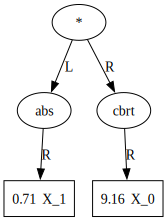

*
abs
X_1
cbrt
X_0
leaves:
X_1
X_0
parent of X_0 is cbrt


In [84]:
tree = generate_initial_solution()
tree.print_tree(VARIABLES_MAP)
tree.draw_tree()
nodes = tree.get_nodes()
for n in nodes:
    print(n.value)

leaves = tree.get_leaves_nodes()
print(f"leaves:")
for l in leaves:
    print(l.value)
leaf = random.choice(leaves)

parent = get_parent(tree.root, leaf)
print(f"parent of {leaf.value} is {parent.value}")

(cos (0.5930240193257564 X_0 ))/ (sin (4.411489354165493 X_1 )) = y


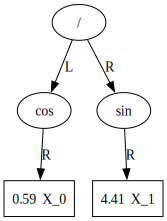

(cos (0.5930240193257564 X_0 ))/ (0.5930240193257564 X_0 ) = y


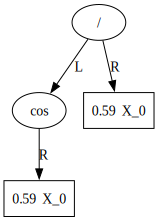

True
( (0.5930240193257564 X_0 ))/ (0.5930240193257564 X_0 ) = y


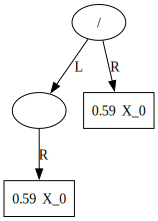

In [85]:
# test = generate_initial_solution()
# test.print_tree(VARIABLES_MAP)
# test.draw_tree()
# collapse_mutation(test)
# test.print_tree(VARIABLES_MAP)
# test.draw_tree()
# print(point_mutation(test))
# test.print_tree(VARIABLES_MAP)
# test.draw_tree()


## Main

  0%|          | 0/250 [00:00<?, ?it/s]

iteration 0 best individual : (np.float64(-27685.71898341634), np.float64(99.7))
new best score : 0.9987968731239615, old score : 0
iteration 100 best individual : (np.float64(-1.2524463045962115), np.float64(98.2))
valhalla
iteration 200 best individual : (np.float64(-1.0615393203245311), np.float64(98.2))
valhalla
Best individual has formula:
(abs (abs (cbrt (arctan (cbrt (arctan (abs (cbrt (5.738717476871739 X_0 )))))))))* (1.0719481735059826 X_0 ) = y
Best individual has fitness: (-1.0615393203245311, 98.2)


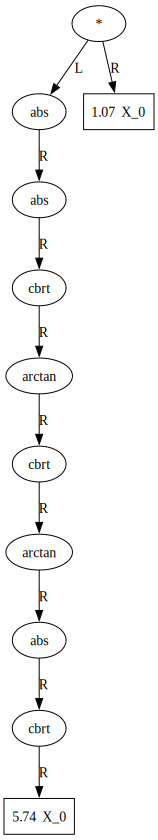

In [91]:
initial_population = [Individual(generate_initial_solution(), 0) for i in range(POPULATION_SIZE)]
# set the fitness
for ind in initial_population:
    ind.fitness = fitness(ind.genome)

# print(initial_population)

best = None
best_score = 0

for i in tqdm(range(MAX_ITERATIONS)):
# for i in range(MAX_ITERATIONS):
    if random.random() < 0.8:
        for _ in range(OFFSPRING_SIZE):
            # crossover
            child, c_fitness = xover(initial_population)
    
            initial_population.append(Individual(child, c_fitness))

    # mutation
    else :
        # take a random individual and mutate it
        ind = random.choice(initial_population)
        mutation(ind.genome)
        # recompute fitness
        ind.fitness = fitness(ind.genome)

    # sort population according to score based on fitness         
    initial_population = sort_individuals(initial_population)
    
    if i % 100 == 0:
        print(f"iteration {i} best individual : {initial_population[0].fitness}")
        # compute score 
        score = compute_score( initial_population[0], initial_population)
        if score > best_score:
            print(f"new best score : {score}, old score : {best_score}")
            best = initial_population[0]
            best_score = score
        # put again the best one in population
        else: 
            print("valhalla")
            initial_population.append(best)
            initial_population = sort_individuals(initial_population)

   
    # remove worst individual
    initial_population = initial_population[:POPULATION_SIZE]


print("Best individual has formula:")
initial_population[0].genome.print_tree(VARIABLES_MAP)
print(f"Best individual has fitness: ({initial_population[0].fitness[0]}, {initial_population[0].fitness[1]})")
initial_population[0].genome.draw_tree()
# initial_population[0].genome.print_tree_values()

